# DSAN 5650 HW2C: Direct and Indirect Causal Pathways (Modeling Languages III)

In [26]:
%config IPCompleter.use_jedi=False

**Assignment Corrections (Run Following Cell to Fetch)**

In [27]:
import corrections
corrections.fetch("HW2C")

**DSAN5650 HW2C Corrections**

None so far!


Last fetched: 2025-07-02 22:53:19 EDT

**Assignment Submission Button (Coming Soon...)**

In [3]:
# 👻👻👻 It will appear here... 👻👻👻

# [Part 4] A Non-Regression Example

You just spent a ton of time estimating regressions -- and, since regression is the workhorse of computational social science (even in the "deep learning era"<sup>[1]</sup>) I think it's worthwhile and I hope you do too 😺. However, to show you that the benefits from learning to speak the PGM language extend far beyond regression, this problem quickly walks you through an example of **detecting changepoints** in historical time-series data.

[Carlin et al. (1992)](https://doi.org/10.2307/2347570) contains a data table with the number of "major coal-mining disasters" (operationalied as incidents where 10 or more miners died) per year from 1851 to 1962. Run the following code cells to plot the trend of this data over time, where you'll maybe start to see (if you squint your eyes enough) that something(s) may have happened around the turn of the 20th century that decreased the yearly disaster rate!

---

<small>

1.  As [a person who professes about ML and stats at Carnegie Mellon](http://bactra.org/) put it back in 2017, *"The dirty secret of the field, and of the current hype, is that [90% of machine learning is a rebranding of nonparametric regression](http://bactra.org/weblog/imf-2017-talk.html)."* Many (most?) statisticians -- at least, among the biased sample of statisticians I know -- would likely still agree with this statement in 2025!

</small>

## [Part 4.1] EDA

In [28]:
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import pymc as pm
import arviz as az

In [29]:
coal_df = pd.read_csv("https://jpj.georgetown.domains/dsan5650-data/coal.csv")
coal_df['source'] = "Observed"
coal_df

,year,disasters,source
0,1851,4,Observed
1,1852,5,Observed
2,1853,4,Observed
3,1854,1,Observed
4,1855,0,Observed
...,...,...,...
107,1958,0,Observed
108,1959,0,Observed
109,1960,1,Observed
110,1961,0,Observed


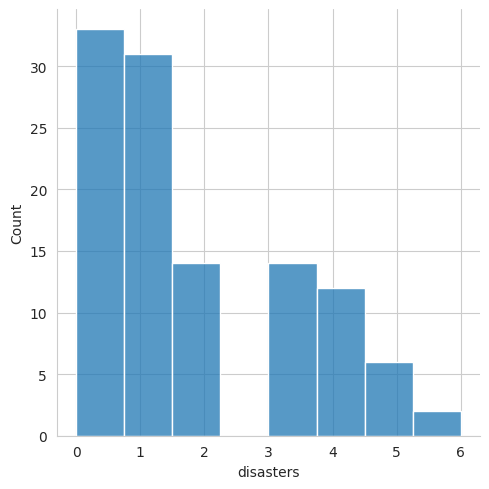

In [30]:
sns.displot(x="disasters", data=coal_df)

In [31]:
first_year = coal_df['year'].min()
last_year = coal_df['year'].max()
mid_year = int(np.floor((first_year + last_year) / 2))
print(first_year, mid_year, last_year)

1851 1906 1962


In [32]:
overall_mean = coal_df['disasters'].mean()
mean_pre = coal_df[coal_df['year'] <= mid_year]['disasters'].mean()
mean_post = coal_df[coal_df['year'] > mid_year]['disasters'].mean()
print(overall_mean, mean_pre, mean_post)

1.7053571428571428 2.517857142857143 0.8928571428571429


Run the following code cell to see a plot of the data using Seaborn:

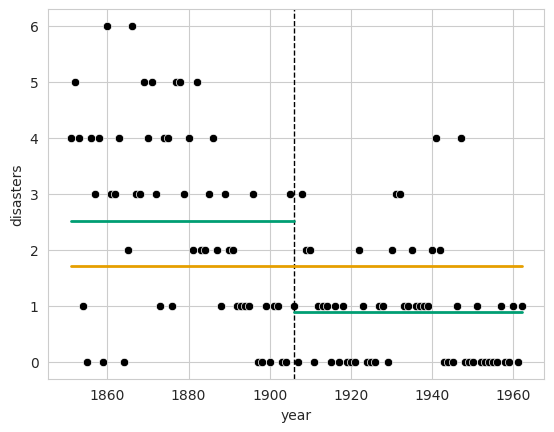

In [33]:
disaster_plot = sns.scatterplot(
    x="year", y="disasters", data=coal_df,
    color="black",
);
plt.axvline(x=mid_year, ls='dashed', lw=1, color='black');
plt.plot(
    [first_year,last_year], [overall_mean,overall_mean],
    color="#e69f00", lw=2
);
plt.plot(
    [first_year,mid_year], [mean_pre, mean_pre],
    [mid_year,last_year], [mean_post, mean_post],
    color="#009e73", lw=2
);

It may not be immediately visually apparent to you that there's a pattern here, at least, relative to how quickly you can identify linear trends (since you've probably had much more training in staring at vaguely-linearly-arranged dots and imagining lines-of-best-fit through them). But, that's because unlike the continuous data we often model via linear regression, this is **count data**.

And, as you may know, unlike the Gaussian/Normal distributions which we arrange across vertical "slices" of data to fit linear regression lines, **counts** are usually better modeled by the **Poisson distribution**<sup>[1]</sup>.

So, with our data-scientist hats on, our first idea may be to try and model each year as an i.i.d. sample from some overall Poisson distribution with parameter $\lambda$. This *base model* is coded and estimated for you in the following code cells, where we also quickly walk you through how you can use **prior predictive sampling** to "test" (informally) the suitability of different choices for priors!

---

<small>

1.  This distribution is especially apt for the task of measuring uncommon **disasters**, since this was the Poisson distribution's first "success story": its use to count horse-kick incidents in the Prussian army ["marked the entry of the Poisson distribution into the 'standard canon' of distributions"](https://x.com/rlmcelreath/status/1821487628094705862).

</small>

In [34]:
year_idx, year_vals = coal_df['year'].factorize()
disaster_vals = coal_df['disasters'].values
coal_df.describe()

,year,disasters
count,112.000000,112.000000
mean,1906.500000,1.705357
std,32.475632,1.647485
min,1851.000000,0.000000
25%,1878.750000,0.000000
50%,1906.500000,1.000000
75%,1934.250000,3.000000
max,1962.000000,6.000000


## [Part 4.2] Our First Try at Disaster Modeling

In [35]:
coords = {'year': year_vals}
with pm.Model(coords=coords) as first_iid_model:
    # Prior on the rate parameter
    # disaster_rate = pm.Uniform("disaster_rate", lower=disaster_vals.min(), upper=disaster_vals.max())
    disaster_rate = pm.Uniform("disaster_rate", lower=1, upper=2)
    disasters = pm.Poisson("disasters", mu=disaster_rate, observed=disaster_vals[year_idx], dims="year")

Sample from prior predictive

In [37]:
with first_iid_model:
    iid_prior_pred_idata = pm.sample_prior_predictive(100, random_seed=5650)

Sampling: [disaster_rate, disasters]


In [38]:
iid_prior_pred_draws = iid_prior_pred_idata.prior_predictive.mean(dim="chain")
iid_prior_pred_draws

<xarray.Dataset> Size: 91kB
Dimensions:    (draw: 100, year: 112)
Coordinates:
  * draw       (draw) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * year       (year) int64 896B 1851 1852 1853 1854 ... 1959 1960 1961 1962
Data variables:
    disasters  (draw, year) float64 90kB 1.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 3.0 0.0

In [41]:
iid_prior_pred_df = iid_prior_pred_draws.to_dataframe().reset_index()
iid_prior_pred_df['source'] = "Predictive Prior Dist"
iid_prior_pred_df

,draw,year,disasters,source
0,0,1851,1.0,Predictive Prior Dist
1,0,1852,0.0,Predictive Prior Dist
2,0,1853,0.0,Predictive Prior Dist
3,0,1854,0.0,Predictive Prior Dist
4,0,1855,0.0,Predictive Prior Dist
...,...,...,...,...
11195,99,1958,1.0,Predictive Prior Dist
11196,99,1959,0.0,Predictive Prior Dist
11197,99,1960,0.0,Predictive Prior Dist
11198,99,1961,3.0,Predictive Prior Dist


In [42]:
iid_prior_combined_df = pd.concat([iid_prior_pred_df, coal_df])
iid_prior_combined_df

,draw,year,disasters,source
0,0.0,1851,1.0,Predictive Prior Dist
1,0.0,1852,0.0,Predictive Prior Dist
2,0.0,1853,0.0,Predictive Prior Dist
3,0.0,1854,0.0,Predictive Prior Dist
4,0.0,1855,0.0,Predictive Prior Dist
...,...,...,...,...
107,NaN,1958,0.0,Observed
108,NaN,1959,0.0,Observed
109,NaN,1960,1.0,Observed
110,NaN,1961,0.0,Observed


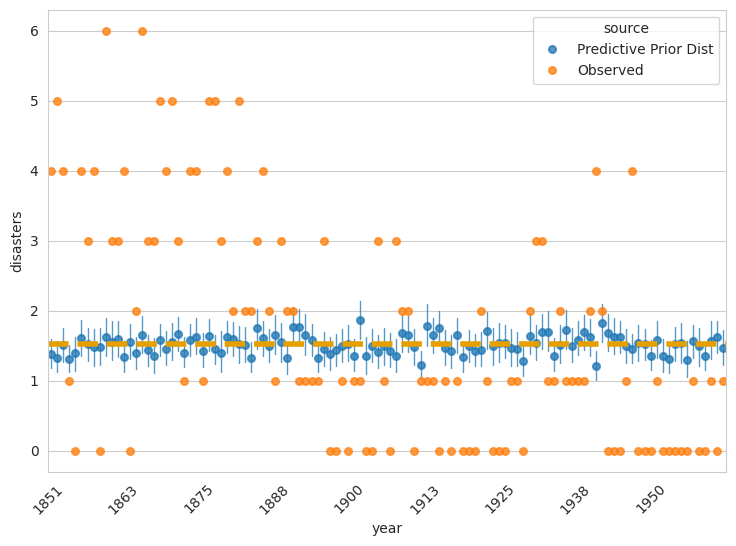

In [43]:
plt.figure(figsize=(8.75,6))
iid_prior_plot = sns.pointplot(
    x='year', y='disasters', hue='source', data=iid_prior_combined_df, lw=2,
    alpha=0.75, linestyle='',
    # color='#56b4e9',
    capsize=0, err_kws=dict(lw=1)
);
iid_prior_plot.xaxis.set_major_locator(ticker.LinearLocator(10))
plt.xticks(rotation=45);
plt.axhline(
    y=iid_prior_pred_idata.prior.mean()['disaster_rate'],
    ls="dashed", lw=4, color='#e69f00'
);

## [Part 4.3] Not Enough Variance! Second Try...

In [44]:
coords = {'year': year_vals}
with pm.Model(coords=coords) as second_iid_model:
    # Prior on the rate parameter
    disaster_rate = pm.Uniform("disaster_rate", lower=disaster_vals.min(), upper=disaster_vals.max())
    disasters = pm.Poisson("disasters", mu=disaster_rate, observed=disaster_vals[year_idx], dims="year")

In [45]:
with second_iid_model:
    iid_prior_pred_idata = pm.sample_prior_predictive(len(coal_df), random_seed=5650)

Sampling: [disaster_rate, disasters]


In [46]:
iid_prior_pred_draws = iid_prior_pred_idata.prior_predictive.mean(dim="chain")
iid_prior_pred_draws

<xarray.Dataset> Size: 102kB
Dimensions:    (draw: 112, year: 112)
Coordinates:
  * draw       (draw) int64 896B 0 1 2 3 4 5 6 7 ... 105 106 107 108 109 110 111
  * year       (year) int64 896B 1851 1852 1853 1854 ... 1959 1960 1961 1962
Data variables:
    disasters  (draw, year) float64 100kB 3.0 2.0 7.0 1.0 ... 8.0 3.0 3.0 1.0

In [47]:
iid_prior_pred_df = iid_prior_pred_draws.to_dataframe().reset_index()
iid_prior_pred_df['source'] = "Prior Predictive Dist"
iid_prior_combined_df = pd.concat([iid_prior_pred_df, coal_df])
iid_prior_combined_df

,draw,year,disasters,source
0,0.0,1851,3.0,Prior Predictive Dist
1,0.0,1852,2.0,Prior Predictive Dist
2,0.0,1853,7.0,Prior Predictive Dist
3,0.0,1854,1.0,Prior Predictive Dist
4,0.0,1855,11.0,Prior Predictive Dist
...,...,...,...,...
107,NaN,1958,0.0,Observed
108,NaN,1959,0.0,Observed
109,NaN,1960,1.0,Observed
110,NaN,1961,0.0,Observed


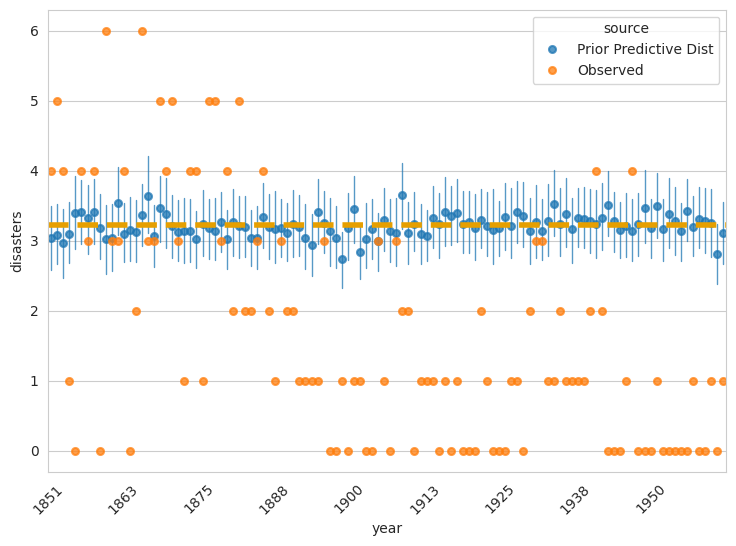

In [48]:
plt.figure(figsize=(8.75,6))
iid_prior_plot = sns.pointplot(
    x='year', y='disasters', hue='source', data=iid_prior_combined_df, lw=2,
    alpha=0.75, linestyle='',
    # color='#56b4e9',
    capsize=0, err_kws=dict(lw=1)
);
iid_prior_plot.xaxis.set_major_locator(ticker.LinearLocator(10))
plt.xticks(rotation=45);
plt.axhline(
    y=iid_prior_pred_idata.prior.mean()['disaster_rate'],
    ls="dashed", lw=4, color='#e69f00'
);

## [Part 4.4] This Count Data is *Overdispersed*! Time to Try Negative Binomial

In [49]:
coords = {'year': year_vals}
with pm.Model(coords=coords) as iid_model:
    # Prior on the rate parameter
    #disaster_rate = pm.Uniform("disaster_rate", lower=disaster_vals.min(), upper=disaster_vals.max())
    disaster_rate = pm.Exponential("disaster_rate", 1)
    #disasters = pm.Poisson("disasters", mu=disaster_rate, observed=disaster_vals[year_idx], dims="year")
    disasters = pm.NegativeBinomial(
        "disasters", mu=disaster_rate, alpha=0.03, observed=disaster_vals[year_idx], dims="year"
    )

In [50]:
with iid_model:
    iid_prior_pred_idata = pm.sample_prior_predictive(len(coal_df), random_seed=5650)

Sampling: [disaster_rate, disasters]


In [52]:
iid_prior_pred_draws = iid_prior_pred_idata.prior_predictive.mean(dim="chain")
iid_prior_pred_df = iid_prior_pred_draws.to_dataframe().reset_index()
iid_prior_pred_df['source'] = "Prior Predictive Dist"
iid_prior_combined_df = pd.concat([iid_prior_pred_df, coal_df])
iid_prior_combined_df

,draw,year,disasters,source
0,0.0,1851,0.0,Prior Predictive Dist
1,0.0,1852,0.0,Prior Predictive Dist
2,0.0,1853,0.0,Prior Predictive Dist
3,0.0,1854,1.0,Prior Predictive Dist
4,0.0,1855,0.0,Prior Predictive Dist
...,...,...,...,...
107,NaN,1958,0.0,Observed
108,NaN,1959,0.0,Observed
109,NaN,1960,1.0,Observed
110,NaN,1961,0.0,Observed


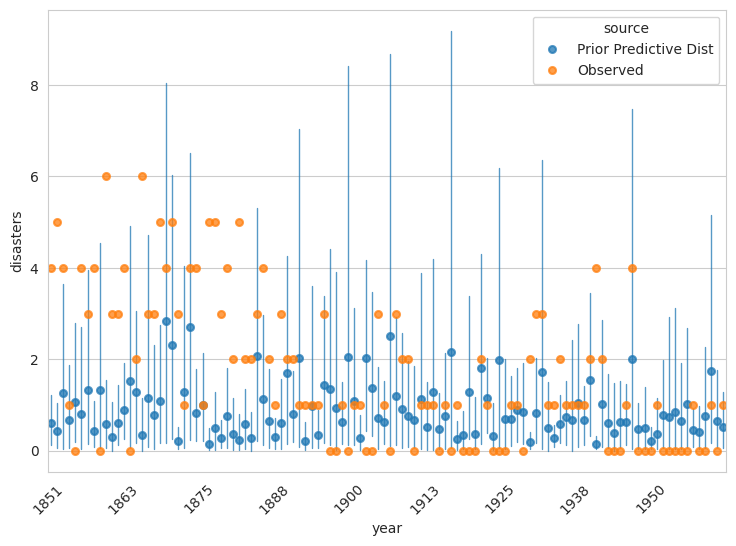

In [53]:
plt.figure(figsize=(8.75,6))
iid_prior_plot = sns.pointplot(
    x='year', y='disasters', hue='source', data=iid_prior_combined_df, lw=2,
    alpha=0.75, linestyle='',
    # color='#56b4e9',
    capsize=0, err_kws=dict(lw=1), errorbar=('ci',99)
);
iid_prior_plot.xaxis.set_major_locator(ticker.LinearLocator(10))
plt.xticks(rotation=45);

Posterior sample

In [54]:
with iid_model:
    iid_post_idata = pm.sample(random_seed=5650)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [disaster_rate]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


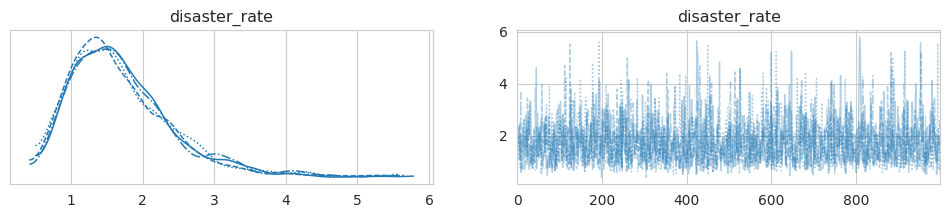

In [27]:
az.plot_trace(iid_post_idata);

In [28]:
az.summary(iid_post_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
disaster_rate,1.706,0.75,0.545,3.038,0.018,0.018,1600.0,2615.0,1.0


In [55]:
iid_post_rate_mean = iid_post_idata.posterior['disaster_rate'].mean(dim=("chain","draw"))
iid_post_rate_mean

<xarray.DataArray 'disaster_rate' ()> Size: 8B
array(1.7062538)

Posterior *predictive* sample

In [60]:
iid_post_thinned = iid_post_idata.sel(draw=slice(None, None, 5))
with iid_model:
    iid_post_pred_idata = pm.sample_posterior_predictive(iid_post_thinned, random_seed=5650)

Sampling: [disasters]


Output()

In [61]:
iid_post_pred_idata.posterior_predictive.dims

FrozenMappingWarningOnValuesAccess({'chain': 4, 'draw': 200, 'year': 112})

In [32]:
az.summary(iid_post_pred_idata.posterior_predictive)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
disasters[1851],0.964,4.680,0.0,3.0,0.166,0.609,887.0,808.0,1.0
disasters[1852],1.326,7.294,0.0,5.0,0.255,1.275,805.0,802.0,1.0
disasters[1853],2.002,10.695,0.0,5.0,0.374,1.722,793.0,738.0,1.0
disasters[1854],1.461,9.748,0.0,4.0,0.345,2.534,801.0,803.0,1.0
disasters[1855],2.155,12.602,0.0,6.0,0.431,2.486,823.0,811.0,1.0
...,...,...,...,...,...,...,...,...,...
disasters[1958],1.259,6.855,0.0,3.0,0.237,1.060,818.0,817.0,1.0
disasters[1959],1.676,10.912,0.0,4.0,0.381,2.579,748.0,746.0,1.0
disasters[1960],2.349,11.481,0.0,7.0,0.393,2.109,832.0,798.0,1.0
disasters[1961],1.246,8.478,0.0,2.0,0.309,2.502,746.0,736.0,1.0


In [62]:
iid_post_pred_means = iid_post_pred_idata.posterior_predictive.mean(dim=("chain"))
iid_post_pred_means

<xarray.Dataset> Size: 182kB
Dimensions:    (draw: 200, year: 112)
Coordinates:
  * draw       (draw) int64 2kB 0 5 10 15 20 25 30 ... 970 975 980 985 990 995
  * year       (year) int64 896B 1851 1852 1853 1854 ... 1959 1960 1961 1962
Data variables:
    disasters  (draw, year) float64 179kB 0.25 3.25 0.0 1.0 ... 0.0 0.0 2.5 0.0

In [57]:
coal_df['disasters_raw'] = coal_df['disasters']
coal_df['disasters'] = coal_df['disasters_raw'].rolling(3).mean()
coal_df

,year,disasters,source,disasters_raw
0,1851,NaN,Observed,4
1,1852,NaN,Observed,5
2,1853,4.333333,Observed,4
3,1854,3.333333,Observed,1
4,1855,1.666667,Observed,0
...,...,...,...,...
107,1958,0.333333,Observed,0
108,1959,0.333333,Observed,0
109,1960,0.333333,Observed,1
110,1961,0.333333,Observed,0


In [63]:
iid_post_pred_df = iid_post_pred_means.to_dataframe().reset_index()
iid_post_pred_df

,draw,year,disasters
0,0,1851,0.25
1,0,1852,3.25
2,0,1853,0.00
3,0,1854,1.00
4,0,1855,0.00
...,...,...,...
22395,995,1958,0.00
22396,995,1959,0.00
22397,995,1960,0.00
22398,995,1961,2.50


In [64]:
iid_post_pred_df['disasters_raw'] = iid_post_pred_df['disasters']
iid_post_pred_df['disasters'] = iid_post_pred_df.groupby('draw')['disasters_raw'].rolling(3).mean().reset_index()['disasters_raw']
iid_post_pred_df['source'] = "Posterior Predictive Dist"
iid_post_combined_df = pd.concat([iid_post_pred_df, coal_df]).reset_index()
iid_post_combined_df

,index,draw,year,disasters,disasters_raw,source
0,0,0.0,1851,NaN,0.25,Posterior Predictive Dist
1,1,0.0,1852,NaN,3.25,Posterior Predictive Dist
2,2,0.0,1853,1.166667,0.00,Posterior Predictive Dist
3,3,0.0,1854,1.416667,1.00,Posterior Predictive Dist
4,4,0.0,1855,0.333333,0.00,Posterior Predictive Dist
...,...,...,...,...,...,...
22507,107,NaN,1958,0.333333,0.00,Observed
22508,108,NaN,1959,0.333333,0.00,Observed
22509,109,NaN,1960,0.333333,1.00,Observed
22510,110,NaN,1961,0.333333,0.00,Observed


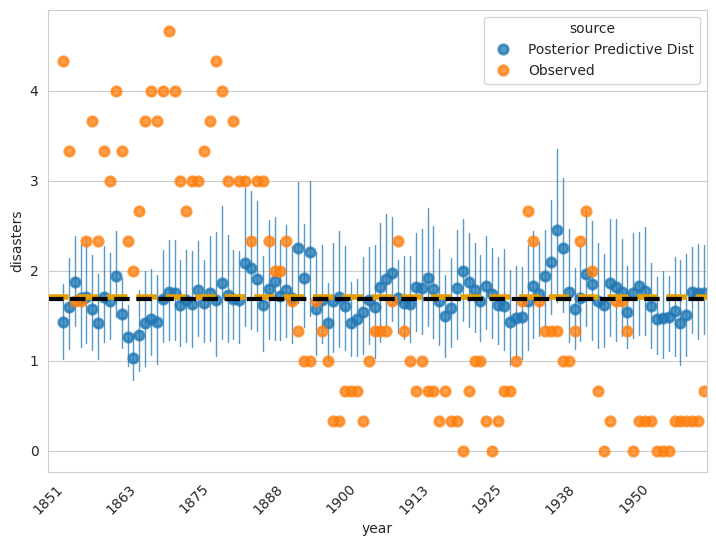

In [65]:
plt.figure(figsize=(8.5,6))
iid_post_plot = sns.pointplot(
    x='year', y='disasters', hue='source', data=iid_post_combined_df,
    linestyle='',
    alpha=0.75, errorbar=('ci',99), err_kws=dict(lw=1)
);
iid_post_plot.xaxis.set_major_locator(ticker.LinearLocator(10))
plt.xticks(rotation=45);
plt.axhline(
    y=iid_post_idata.posterior.mean()['disaster_rate'],
    ls="dashed", lw=4, color='#e69f00'
);
plt.axhline(
    y=coal_df['disasters'].mean(),
    ls="dashed", lw=3, color='black'
);

## [Question 4.5] Your Turn! Find the Cutpoint

Once you've successfully implemented the model, repeat the above steps (but with `cutpoint_model` instead of `iid_model`) to generate a plot of the posterior mean disaster counts! The final result should look approximately like the following:

<center>
<figure>
<img src="https://github.com/jpowerj/dsan-content/blob/main/2025-sum-dsan5650/hw2/cutpoint_posterior.png?raw=true" width="70%"></img>
</figure>
</center>

In [66]:
disaster_vals = coal_df['disasters_raw'].values
year_idx, year_vals = coal_df['year'].factorize()
year_vals = np.array(year_vals)
coords = {'year': year_vals}
with pm.Model(coords=coords) as cutpoint_model:
    # Your code here: Define the cutpoint RV
    first_year = year_vals.min()
    last_year = year_vals.max()
    mid_year = int(np.floor((first_year + last_year) / 2))
    # disaster values before the cutpoint
    disaster_vals_bf = coal_df.loc[coal_df['year']<mid_year,'disasters_raw'].values 
    # disaster values after the cutpoint
    disaster_vals_af = coal_df.loc[coal_df['year']>=mid_year,'disasters_raw'].values 
    
    # Your code here: Priors for rates before and after the cutpoint
    # priors for rates before the cutpoint
    disaster_rate_bf = pm.Uniform("disaster_rate_bf", lower=disaster_vals_bf.min(), upper=disaster_vals_bf.max())
    # priors for rates after the cutpoint
    disaster_rate_af = pm.Uniform("disaster_rate_af", lower=disaster_vals_af.min(), upper=disaster_vals_af.max())
    
    # Your code here: Implement a "switch" (<- hint) which activates the correct
    # prior for the datapoint's year
    disaster_rate = pm.math.switch(
        year_vals[year_idx] < mid_year,
        disaster_rate_bf,
        disaster_rate_af
    )
    
    # Free final line: The final NegativeBinomial RV should look as follows!
#    disasters = pm.NegativeBinomial(
#        "disasters", mu=disaster_rate, alpha=0.01, observed=disaster_vals[year_idx],  dims='year'
#    )

    # (If estimation for the NegativeBinomial is too erratic, you can comment
    # the above NB out and uncomment the following line to switch back to the
    # easier-to-estimate Poisson form)
    disasters = pm.Poisson("disasters", mu=disaster_rate, observed=disaster_vals[year_idx], dims="year")

In [67]:
# Posterior predictive distribution
with cutpoint_model:
    cutpoint_post_data = pm.sample(random_seed=1965)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [disaster_rate_bf, disaster_rate_af]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [68]:
# Use the computed values of disaster_rate
with cutpoint_model:
    cutpoint_post_pred_data = pm.sample_posterior_predictive(cutpoint_post_data)

Sampling: [disasters]


Output()

In [69]:
# Post pred means
cutpoint_post_pred_means = cutpoint_post_pred_data.posterior_predictive.mean(dim=("chain"))
cutpoint_post_pred_means

<xarray.Dataset> Size: 905kB
Dimensions:    (draw: 1000, year: 112)
Coordinates:
  * draw       (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * year       (year) int64 896B 1851 1852 1853 1854 ... 1959 1960 1961 1962
Data variables:
    disasters  (draw, year) float64 896kB 3.5 3.5 3.75 2.25 ... 1.5 0.25 0.75

In [14]:
# Post pred data
cutpoint_post_pred_df = cutpoint_post_pred_means.to_dataframe().reset_index()
cutpoint_post_pred_df

,draw,year,disasters
0,0,1851,1.25
1,0,1852,2.25
2,0,1853,3.25
3,0,1854,2.75
4,0,1855,3.25
...,...,...,...
111995,999,1958,0.50
111996,999,1959,1.25
111997,999,1960,1.75
111998,999,1961,1.25


In [70]:
# Smooth the disasters_raw values by rolling mean on 3 years
cutpoint_post_pred_df['disasters_raw'] = cutpoint_post_pred_df['disasters']
cutpoint_post_pred_df['disasters'] = cutpoint_post_pred_df.groupby('draw')['disasters_raw'].rolling(3).mean().reset_index()['disasters_raw']
cutpoint_post_pred_df['source'] = "Posterior Predictive Dist"


In [71]:
cutpoint_post_combined_df = pd.concat([coal_df,cutpoint_post_pred_df]).reset_index()
cutpoint_post_combined_df

,index,year,disasters,source,disasters_raw,draw
0,0,1851,NaN,Observed,4.000000,NaN
1,1,1852,NaN,Observed,5.000000,NaN
2,2,1853,4.333333,Observed,4.000000,NaN
3,3,1854,3.333333,Observed,1.000000,NaN
4,4,1855,1.666667,Observed,0.000000,NaN
...,...,...,...,...,...,...
112107,111995,1958,1.138889,Posterior Predictive Dist,0.833333,999.0
112108,111996,1959,0.888889,Posterior Predictive Dist,0.750000,999.0
112109,111997,1960,0.916667,Posterior Predictive Dist,1.166667,999.0
112110,111998,1961,1.111111,Posterior Predictive Dist,1.416667,999.0


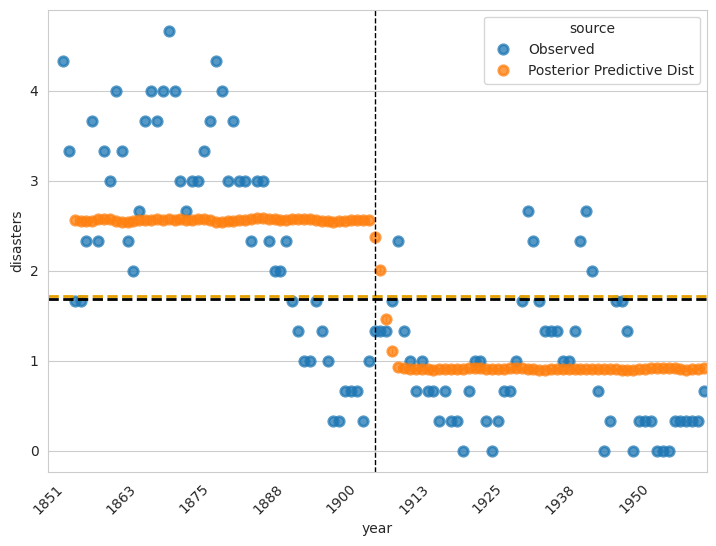

In [74]:
plt.figure(figsize=(8.5,6))
cutpoint_post_plot = sns.pointplot(
    x='year', y='disasters', hue='source', data=cutpoint_post_combined_df,
    linestyle='',
    alpha=0.75, errorbar=('ci',99), err_kws=dict(lw=1)
);
cutpoint_post_plot.xaxis.set_major_locator(ticker.LinearLocator(10))
plt.xticks(rotation=45);
plt.axhline(
    y=cutpoint_post_pred_df['disasters'].mean(),
    ls="dashed", lw=2, color='#e69f00'
);
plt.axhline(
    y=coal_df['disasters'].mean(),
    ls="dashed", lw=2, color='black'
);

plt.axvline(
    x=str(mid_year),
    ls="dashed", lw=1, color='black'
);


# [Part 5] $\textsf{do}()$in Thangs: The Firing Squad

<center>
<figure>
<img src="https://github.com/jpowerj/dsan-content/blob/main/2025-sum-dsan5650/hw2/big_bear.jpg?raw=true" width="50%"></img>
<figcaption><i>Look, it's just, the best album cover of all time. I can't pass up this opportunity...</i></figcaption>
</figure>
</center>

The necessary background/intuition for this part can be found in pages 50-53 of Pearl and Mackenzie (2018)... Lucky for you, those pages are copied in the following cell! I've also added three of my own highlights, for the most important pieces to focus on.

**Pearl and Mackenzie (2018) I: The Firing Squad**

> Suppose that a prisoner is about to be executed by a firing squad. A certain chain of events must occur for this to happen. First, the court orders the execution. The order goes to a captain, who signals the soldiers on the firing squad ($A$ and $B$) to fire. We’ll assume that they are obedient and expert marksmen, so they only fire on command, and if either one of them shoots, the prisoner dies.
>
> Figure 1.4 shows a diagram representing the story I just told. Each of the unknowns ($CO$, $C$, $A$, $B$, $D$) is a true/false variable. For example, $D$ = true means the prisoner is dead; $D$ = false means the prisoner is alive. $CO$ = false means the court order was not issued; $CO$ = true means it was, and so on.
> 
> <center>
> <figure>
>     <img src="https://github.com/jpowerj/dsan-content/blob/main/2025-sum-dsan5650/hw2/pearl_firing_squad.png?raw=true" width="25%"></img>
>     <figcaption><i>Figure 1.4 from Pearl and Mackenzie (2018)</i></figcaption>
> </figure>
> </center>
> 
> Using this diagram, we can start answering causal questions from different rungs of the ladder. First, we can answer questions of association (i.e., what one fact tells us about another).
> 
> <center>
> <figure>
> <span style='background-color: rgba(255,220,116,0.5);'><b>If the prisoner is dead, does that mean the court order was given?</b></span>
> <figcaption><i>[This is a question that can be answered within "Level 1" -- the <b>associational</b> level -- of the Ladder of Causal Inference]</i></figcaption>
> </figure>
> </center>
> 
> We (or a computer) can inspect the graph, trace the rules behind each of the arrows, and, using standard logic, conclude that the two soldiers wouldn’t have fired without the captain’s command. Likewise, the captain wouldn’t have given the command if he didn’t have the order in his possession. Therefore the answer to our query is yes.
> 
> Alternatively, suppose we find out that $A$ fired. What does that tell us about $B$? By following the arrows, the computer concludes that $B$ must have fired too. ($A$ would not have fired if the captain hadn’t signaled, so $B$ must have fired as well.) This is true even though $A$ does not cause $B$ (there is no arrow from $A$ to $B$).
> 
> Going up the Ladder of Causation, we can ask questions about intervention. What if Soldier $A$ decides on his own initiative to fire, without waiting for the captain’s command? Will the prisoner be dead or alive? This question in fact already has a contradictory flavor to it. I just told you that $A$ only shoots if commanded to, and yet now we are asking what happens if he fired without a command. If you’re just using the rules of logic, as computers typically do, the question is meaningless. As the robot in the 1960s sci-fi TV series Lost in Space used to say in such situations, "That does not compute."
> 
> If we want our computer to understand causation, we have to teach it how to break the rules. We have to teach it the difference between merely observing an event and making it happen.
> 
> <center>
> <figure>
> <span style='background-color: rgba(255,220,116,0.5);'><b>"Whenever you make an event happen," we tell the computer, "remove all arrows that point to that event and continue the analysis by ordinary logic, as if the arrows had never been there."</b></span>
> <figcaption><i>[This is <b>exactly the $do()$ algorithm</b>, in words, in terms of how it modifies a pre-intervention PGM!]</i></figcaption>
> </figure>
> </center>
> 
> Thus, we erase all the arrows leading into the intervened variable ($A$). We also set that variable manually to its prescribed value (true). The rationale for this peculiar "surgery" is simple: making an event happen means that you emancipate it from all other influences and subject it to one and only one influence -- that which enforces its happening.
>
> **Figure 1.5** shows the causal diagram that results from our example. This intervention leads inevitably to the prisoner's death. That is the causal function behind the arrow leading from $A$ to $D$.
>
> <center>
> <figure>
> <img src="https://github.com/jpowerj/dsan-content/blob/main/2025-sum-dsan5650/hw2/pearl_firing_squad_do.png?raw=true" width="35%"></img>
> <figcaption><i>Figure 1.5 from Pearl and Mackenzie (2018)</i></figcaption>
> </figure>
> </center>
>
> Note that this conclusion agrees with our intuitive judgment that $A$'s unauthorized firing will lead to the prisoner's death, because the surgery leaves the arrow from $A$ to $D$ intact. Also, our judgment would be that $B$ (in all likelihood) did not shoot; nothing about $A$'s decision should affect variables in the model that are not effects of $A$'s shot. This bears repeating. If we see $A$ shoot, then we conclude that $B$ shot too. But if $A$ decides to shoot, or if we make $A$ shoot, then the opposite is true. This is the difference between seeing and doing. Only a computer capable of grasping this difference can pass the mini-Turing test.
>
> Note also that
>
> <center>
> <figure>
> <span style='background-color: rgba(255,220,116,0.5);'><b>merely collecting Big Data would not have helped us ascend the ladder and answer the above questions.</b></span>
> </figure>
> </center>
> 
> Assume that you are a reporter collecting records of execution scenes day after day. Your data will consist of two kinds of events: either all five variables are true, or all of them are false. There is no way that this kind of data, in the absence of an understanding of who listens to whom, will enable you (or any machine learning algorithm) to predict the results of persuading marksman $A$ not to shoot.

The summary of $\textsf{do}()$ in the above excerpt does a pretty good job of capturing the intuition behind how the $\textsf{do}()$ operator actually works:

* The standard $\Pr()$ operator from probability theory is based on "passively" observing the values of variables within a causal system, and counting co-occurrences of values
    * For example, in a discrete system at least, $\Pr(Y = y \mid X = x)$ is just $\frac{\#[X = x, Y = y]}{\#[X = x]}$
* The $\textsf{do}()$ operator actually **changes** the flow of causal information within the causal system itself, thus changing the PGM (rather than just counting the co-occurrences of values across different variables!)

After you have **modified** a PGM $\mathcal{M}$ via the "$\textsf{do}(X = x)$ rule" (Sever all causal links going into $X$, set $X$'s value to be $x$, then "restart" the causal flow), you obtain a new PGM $\mathcal{M}' = [\mathcal{M} \mid \textsf{do}(X = x)]$ (for which we'll use $\mathcal{M}_{\textsf{do}(X = x)}$ as shorthand) with which you can go back to using the regular old $\Pr()$ operator, now imbued with a **causal interpretation** conditional on $X$ taking the value $x$:

<table>
<thead>
<tr>
    <th></th>
    <th>Mathematical Notation</th>
    <th>Details</th>
    <th>Semantic Interpretation</th>
</tr>
</thead>
<tbody>
<tr>
    <td><b>Before $\textsf{do}(X = 5)$</b></td>
    <td>A PGM $\mathcal{M}$</td>
    <td>Encodes probabilistic relationships among events (or Random Variables) with respect to the "standard" $\Pr()$ function</td>
    <td rowspan="3">"A model of probabilistic relationships among RVs $X$, $Y$, and $Z$"</td>
</tr>
<tr>
    <td align="right">&#8627;</td>
    <td>$\Pr(e_1)$</td>
    <td>The "base" $\Pr()$ function can be used to ask things like $\Pr(e_1)$, the probability of an event $e_1$ happening (with respect to the set of all possible outcomes $\Omega$).<br><br>Given the definition of a (discrete) Random Variable, we can also ask e.g., $\Pr(Y = 7)$, where $Y$ is some mapping from things in $\Omega$ to things in $\mathbb{Z}$, so that $Y = 7$ is the event that the outcome of some uncertain procedure (say, the sum of two dice rolls) is mapped by $Y$ to $7$.</td>
</tr>
<tr>
    <td align="right">&#8627;</td>
    <td>$\Pr_{e_0}(e_1)$<br>$\equiv \Pr(e_1 \mid e_0)$</td>
    <td>To answer the slightly more complicated query "I've observed another event $e_0$. What is $\Pr(e_1)$ now?", we could use a subscript like $\Pr_{e_0}(e_1)$ to denote the probability of $e_1$ with respect to just $\Omega_{e_0}$, the subset of outcomes in $\Omega$ where $e_0$ happens.<br><br>The notation $\Pr(e_1 \mid e_0)$ is a nice shorthand for this, since now we know everything within the $()$ is some event, and other characters tell us the relations between these events (like "$\cup$" to mean <i>or</i>, and "|" to mean <i>given</i>)</td>
</tr>
<tr>
    <td><b>After $\textsf{do}(X = 5)$</b></td>
    <td>A <b>new</b> PGM $\mathcal{M}' = \mathcal{M}_{\textsf{do}(X = 5)}$</td>
    <td>$\mathcal{M}_{\textsf{do}(X = 5)}$ contains the same nodes, but represents a <b>new stochastic system</b>: the system (i.e., the collection of probabilistic relationships) which comes into being after <b>intervening to force $X$ to have the value $5$</b>.</td>
    <td rowspan="2">"A model of probabilistic relationships among RVs $X$, $Y$, and $Z$ after <b>intervening</b> to force $X$ to have the value 5"</td>
</tr>
<tr>
    <td align="right">&#8627;</td>
    <td>$\Pr_{\textsf{do}(X = 5)}(e_1)$<br>$\equiv \Pr(e_1 \mid \textsf{do}(X = 5))$</td>
    <td>This gives us a whole new $\Pr_{\textsf{do}(X = 5)}()$ function, interpreted with respect to the semantics of $\mathcal{M}_{\textsf{do}(X = 5)}$ described in the previous row.</td>
</tr>
</tbody>
</table>

## [Question 5.1] Firing Squad in PyMC

In [75]:
import numpy as np
rng = np.random.default_rng(5650)
import matplotlib.pyplot as plt
import seaborn as sns

import arviz as az
import graphviz as gr
import pymc as pm
# This enables *control flow* operations like if-else!
import pytensor.tensor as pt
# The magical do() operator
from pymc.model.transform.conditioning import do

**Question 5.1a: Implementing the Firing Squad PGM**

Once implemented, the call to `pm.model_to_graphviz(fs_model)` should produce the following PGM:

<center>
<figure>
<img src="https://raw.githubusercontent.com/jpowerj/dsan-content/2dbc33a9bfca26c00e98d297c398c0a2c3366ad2/2025-sum-dsan5650/hw2/pearl_firing_squad_pymc.svg" width="30%"></img>
</figure>
</center>

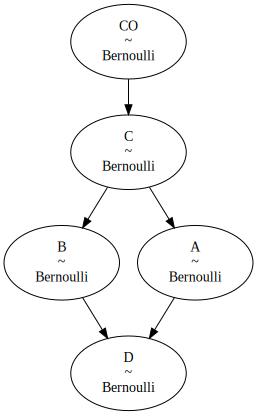

In [76]:
# @title Q5.1a-response
with pm.Model() as fs_model:
    # Your code here: implement the firing squad as a PyMC model!
 
    CO = pm.Bernoulli("CO", p = 0.5)
    C = pm.Bernoulli("C", p = CO)
    A = pm.Bernoulli("A", p = C)
    B = pm.Bernoulli("B", p = C)
    D = pm.Bernoulli('D', p = pm.math.maximum(A, B))

pm.model_to_graphviz(fs_model)

**Question 5.1b: Sampling from the Firing Squad PGM**

In [77]:
# @title Q5.1b-response
# Your code here: Use pm.sample() to estimate posterior means
with fs_model:
    fs_trace = pm.sample(random_seed = 1296)
fs_post_mean = fs_trace.posterior.mean(dim =("chain", "draw"))
fs_post_mean
# Once fs_trace is produced, the following line will print out a summary table
az.summary(fs_trace)

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [CO, C, A, B, D]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
/opt/tljh/user/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/tljh/user/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/tljh/user/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
CO,1.0,0.0,1.0,1.0,0.0,NaN,4000.0,4000.0,NaN
C,1.0,0.0,1.0,1.0,0.0,NaN,4000.0,4000.0,NaN
A,1.0,0.0,1.0,1.0,0.0,NaN,4000.0,4000.0,NaN
B,1.0,0.0,1.0,1.0,0.0,NaN,4000.0,4000.0,NaN
D,1.0,0.0,1.0,1.0,0.0,NaN,4000.0,4000.0,NaN


## [Question 5.2] Causal Impact of $A$

**Question 5.2a: Implementing $\textsf{do}(A \leftarrow 1)$**

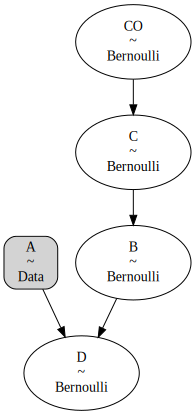

In [78]:
# @title Q5.2a-response
do_A1_model = pm.do(model=fs_model,vars_to_interventions={"A": 1}) # Your code here: replace with call to do()
if do_A1_model is not None:
    display(pm.model_to_graphviz(do_A1_model))

**Question 5.2b: Sampling from the Post-Intervention PGM**

In [79]:
# Your code here: use pm.sample() to estimate posterior means
with do_A1_model:
    do_A1_trace = pm.sample(random_seed=1296)
do_A1_post_mean = do_A1_trace.posterior.mean(dim=("chain", "draw"))
az.summary(do_A1_trace)

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [CO, C, B, D]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
/opt/tljh/user/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/tljh/user/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/tljh/user/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
CO,1.0,0.0,1.0,1.0,0.0,NaN,4000.0,4000.0,NaN
C,1.0,0.0,1.0,1.0,0.0,NaN,4000.0,4000.0,NaN
B,1.0,0.0,1.0,1.0,0.0,NaN,4000.0,4000.0,NaN
D,1.0,0.0,1.0,1.0,0.0,NaN,4000.0,4000.0,NaN


**Question 5.2b: Implementing $\textsf{do}(A \leftarrow 0)$**

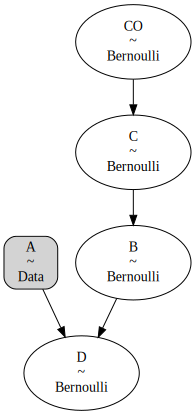

In [80]:
# @title Q5.2b-response
do_A0_model = pm.do(model=fs_model, vars_to_interventions={"A": 0}) # Your code here: replace with call to do()
if do_A0_model is not None:
    display(pm.model_to_graphviz(do_A0_model))

In [83]:
# Your code here: use pm.sample() to estimate posterior means
with do_A0_model:
    do_A0_trace = pm.sample(random_seed=1296)
do_A0_post_mean = do_A0_trace.posterior.mean(dim=("chain", "draw"))
# Once do_A0_trace is produced, the following line will print out a summary table
az.summary(do_A0_trace)

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [CO, C, B, D]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
/opt/tljh/user/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/tljh/user/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/tljh/user/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
CO,1.0,0.0,1.0,1.0,0.0,NaN,4000.0,4000.0,NaN
C,1.0,0.0,1.0,1.0,0.0,NaN,4000.0,4000.0,NaN
B,1.0,0.0,1.0,1.0,0.0,NaN,4000.0,4000.0,NaN
D,1.0,0.0,1.0,1.0,0.0,NaN,4000.0,4000.0,NaN


**Question 5.2c: Compute the Causal Impact of $\textsf{do}(A)$**

In [84]:
# @title Q5.2e-response

# Predictive sample of do(A=1)
do_A1_model = pm.do(model = fs_model, vars_to_interventions={"A": 1})
with do_A1_model:
    do_A1_post_pred = pm.sample_posterior_predictive(trace=pm.sample(), var_names=["D"], random_seed=1296)

# Predicted D value under do(A=1)
pred_D_do_A1 = do_A1_post_pred.posterior_predictive.to_dataframe()["D"].mean()

# Predictive sample of do(A=0)
do_A0_model = pm.do(model = fs_model, vars_to_interventions={"A": 0})
with do_A0_model:
    do_A0_post_pred = pm.sample_posterior_predictive(trace=pm.sample(), var_names=["D"], random_seed=1123)

# Predicted D value under do(A=0)
pred_D_do_A0 = do_A0_post_pred.posterior_predictive.to_dataframe()["D"].mean()


q5_2e_response = pred_D_do_A1 - pred_D_do_A0 # Your code here: replace with computation of do(A) effect on D

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [CO, C, B, D]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
/opt/tljh/user/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
Sampling: [D]


Output()

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [CO, C, B, D]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
/opt/tljh/user/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
Sampling: [D]


Output()

## [Question 5.3] Implementing $\textsf{do}(A \leftarrow 0, B \leftarrow 0)$

In [59]:
# @title Q5.3-response
do_A0B0_model = pm.do(fs_model, vars_to_interventions={"A":0, "B":0}) # Your code here: replace with call to do()
if do_A0B0_model is not None:
    display(pm.model_to_graphviz(do_A0B0_model))

## [Question 5.4] Causal Impact of $C$

**Question 5.4a: Implementing $\textsf{do}(C \leftarrow 1)$**

In [85]:
# @title Q5.4a-response
do_C1_model = pm.do(fs_model, vars_to_interventions={"C": 1}) # Your code here: replace with call to do()
if do_C1_model is not None:
    pm.model_to_graphviz(do_C1_model)

**Question 5.4b: Sampling from the Post-Intervention PGM**

In [86]:
# @title Q5.4b-response
# Your code here: use pm.sample() to estimate posterior means
with do_C1_model:
    do_C1_trace = pm.sample(model=do_C1_model, random_seed=1296)
az.summary(do_C1_trace)

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [CO, A, B, D]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
/opt/tljh/user/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/tljh/user/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/tljh/user/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
CO,0.497,0.5,0.0,1.0,0.004,0.0,14408.0,4000.0,1.0
A,1.000,0.0,1.0,1.0,0.000,NaN,4000.0,4000.0,NaN
B,1.000,0.0,1.0,1.0,0.000,NaN,4000.0,4000.0,NaN
D,1.000,0.0,1.0,1.0,0.000,NaN,4000.0,4000.0,NaN


**Question 5.4c: Implementing $\textsf{do}(C \leftarrow 0)$**

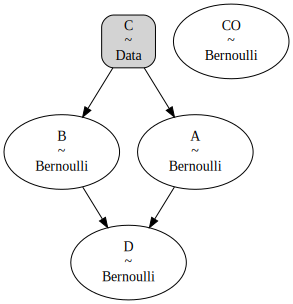

In [87]:
# @title Q5.4c-response
do_C0_model = pm.do(model=fs_model, vars_to_interventions={"C" : 0}) # Your code here: replace with call to do()
if do_C0_model is not None:
    display(pm.model_to_graphviz(do_C0_model))

**Question 5.4d: Sampling from the Post-Intervention PGM**

In [88]:
# @title Q5.4d-response
# Your code here: use pm.sample() to estimate posterior means
with do_C0_model:
    do_C0_trace = pm.sample(random_seed=1296)
do_C0_post_mean = do_C0_trace.posterior.mean(dim=("chain", "draw"))
az.summary(do_C0_trace)

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [CO, A, B, D]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
/opt/tljh/user/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/tljh/user/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/tljh/user/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
CO,0.497,0.5,0.0,1.0,0.004,0.0,14408.0,4000.0,1.0
A,0.000,0.0,0.0,0.0,0.000,NaN,4000.0,4000.0,NaN
B,0.000,0.0,0.0,0.0,0.000,NaN,4000.0,4000.0,NaN
D,0.000,0.0,0.0,0.0,0.000,NaN,4000.0,4000.0,NaN


**Question 5.4e: Compute the Causal Impact of $\textsf{do}(C)$**

In [89]:
# @title Q5.4e-response

# Predictive sample of do(C=1)
do_C1_model = pm.do(model=fs_model, vars_to_interventions={"C" : 1})
with do_C1_model:
    do_C1_post_pred = pm.sample_posterior_predictive(trace=pm.sample(), var_names=["D"], random_seed=1234)

# Predicted D when do(C=1)
pred_D_do_C1 = do_C1_post_pred.posterior_predictive.to_dataframe()["D"].mean()

# Predictive sample of do(C=0)
do_C0_model = pm.do(model=fs_model, vars_to_interventions={"C" : 0})
with do_C0_model:
    do_C0_post_pred = pm.sample_posterior_predictive(trace=pm.sample(), var_names=["D"], random_seed=1234)

# Predicted D when do(C=0)
pred_D_do_C0 = do_C0_post_pred.posterior_predictive.to_dataframe()["D"].mean()

q5_4e_response = pred_D_do_C1 - pred_D_do_C0 # Your code here: replace with computation of do(C) effect on D

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [CO, A, B, D]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
/opt/tljh/user/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
Sampling: [D]


Output()

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [CO, A, B, D]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
/opt/tljh/user/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
Sampling: [D]


Output()